# Summary

## Implementation of The 10-armed Testbed using *Gradient Bandit* algorithm, as discussed in section 2.8 of Sutton & Barto book [1]
- Shows the performance on the 10-armed bandit testbed in a stationary problem.
    - Results for alpha = 0.1 and for alpha = 0.4, with or without baseline term.        
    - True actions values were selected according to a normal distribution with a mean of +4 instead of zero (and with unit variance as before)

[1] Sutton, R. S. & Barto, A. G. (2018), Reinforcement Learning: An Introduction, The MIT Press.

In [1]:
#Import statements
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [2]:
def plot_results(returns):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
    # Plotting average reward per time step    
    for k, v in returns.items():
        y = np.mean(v['R'], axis=0)
        x = np.arange(0, len(y))
        ax[0,0].plot(x, y, label=k)

    ax[0,0].set(title='Rewards',
           ylabel='Average Reward',
           xlabel='')
    ax[0,0].legend(loc='lower right') 

    # Plotting % optimal actions taken when in time-step t
    for k, v in returns.items():
        y = np.mean(v['opt_A'], axis=0)
        x = np.arange(0, len(y))
        ax[0,1].plot(x, y, label=k)

    ax[0,1].set(title='Actions',
           ylabel='% Optimal Actions',
           xlabel='')    
    ax[0,1].legend(loc='lower right') 
    
    # Plotting average cumulative reward per time step    
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['R'], axis=1), axis=0)
        x = np.arange(0, len(y))
        ax[1,0].plot(x, y, label=k)

    ax[1,0].set(title='',
           ylabel='Average Reward - Cumulative',
           xlabel='Time')
    ax[1,0].legend(loc='lower right') 

    # Plotting average % optimal actions
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['opt_A'], axis=1)/v['opt_A'].shape[1], axis=0)
        x = np.arange(0, len(y))
        ax[1,1].plot(x, y, label=k)

    ax[1,1].set(title='',
           ylabel='Average % Optimal Actions - Cumulative',
           xlabel='Time')    
    ax[1,1].legend(loc='lower right') 
    
    #fig.tight_layout()
    plt.show()

In [3]:
def take_action(A, pi):
    '''
    Selects action according to probabilities.
    
    Parameters
    ----------
    A : array_like
        Actions set.
    pi : array_like
        Probability of taking action a at time t for each action.
        
    Returns
    -------
    int
        Action taken.
    
    '''
    return np.random.choice(A, p=pi)

def update_h(H, R_t, pi, alpha, baseline, At):
    '''
    Updates numerical preferences for each action.    
    
    Parameters
    ----------
    H : array_like
        Numerical preferences for each action at a time step t
    R_t : float
        Reward received in current time step.
    alpha : float
        Step-size parameter. 0 <= alpha < 1
    baseline : float
        Baseline value for H update. 
        
    Returns
    -------
    float
        Estimated value of an action a after its n-th selection.
        
    '''
    
    # Gets numerical preference for action taken At
    H_a = H[At]

    # Updating H
    H = H - alpha*(R_t - baseline)*pi
    H[At] = H_a + alpha*(R_t - baseline)*(1 - pi[At])
        
    return H

def get_bandit_reward(action_true_value, rewards_var):
    '''
    Gets the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
    
    Parameters
    ----------
    action_true_value : float
        Mean of the normal distribution.
    rewards_var : float
        Variance of the normal distribution.
        
    Returns
    -------
    float
        Reward sampled.    
    
    '''    
    return np.random.default_rng().normal(action_true_value, np.sqrt(rewards_var))


def run_episode_gradient(action_true_values, rewards_var, T, alpha, baseline=None):
    '''
    Runs an episode (a "run") where Gradient Bandit algorithm is applied to the k-armed bandit problem.    
    
    Parameters
    ----------
    action_true_values : array_like
        True values of the actions based on a specific distribution. Actions are choosen according to this distribution.
    rewards_var : float
        Variance of the reward distribution for each action.
    T : int
        Length of the episode (in time steps)
    alpha : float
        Step-size parameter. 0 <= alpha < 1
    baseline : float
        If None uses the average of the rewards as baseline.
        
    Returns
    -------
    pi : array_like
        Probability of taking actions after T steps.
    R : array_like
        Rewards obtained in each time step.
    opt_A : array_like
        1 if action taken in time step t was optimal (best action), 0 otherwise.       
    
    '''
    # Initializing
    t = 0 # Time-step
    nA = len(action_true_values) # Number of actions
    A = np.arange(0, nA) # Set of actions
    H = np.zeros_like(A) # Numerical preference for every action at some time step t 
    pi = softmax(H) # Probability of taking action at time t for every action
    R = np.zeros(T) # Rewards over time
    opt_A = np.zeros(T) # 1 if action taken in time step t was optimal, 0 otherwise
    optimal_action = np.argmax(action_true_values) # Optimal action for this instance.
    
    # A run (T time steps)
    while t < T:
        # Taking action
        action = take_action(A, pi)
        
        # Counting optimal
        if action == optimal_action:
            opt_A[t] += 1
            
        # Getting the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
        R[t] = get_bandit_reward(action_true_values[action], rewards_var)
        
        # Sets baseline
        if baseline is None:
            baseline = R[:t+1].mean()
        
        # Updating numerical preferences and pi
        H = update_h(H, R[t], pi, alpha, baseline, action)
        pi = softmax(H)
        
        # Ending current time step
        t += 1
        
    return pi, R, opt_A

def simulate(k, total_runs, rewards_var, T, alpha, baseline=None):
    '''
    Simulate several instances of k-armed bandit problem
    
    Parameters
    ----------    
    k : int
        Number of actions, i.e., how many arms the bandit has.
    total_runs : int
        Number of randomly generated k-armed bandit problems. How many times the problem will be simulated.
    rewards_var : float
        Variance of the reward distribution for each action.    
    T : int
        Duration of a single problem (total of time steps).
    alpha : float
        Step-size parameter. 0 <= alpha < 1
    baseline : float
        If None uses the average of the rewards as baseline.
    
        
    Returns
    -------
    H : array_like 
        Numerical preferences for each action at the end of each run.
    R : array_like
        Matrix with returns per time for every run.
    opt_A : array_like
        For every run and every time step informs if the optimal action was the action taken. 
        Gives 1 if action taken in time step t was optimal, 0 otherwise
    
    '''
    H = np.zeros((total_runs,k))
    R = np.zeros((total_runs,T))
    opt_A = np.zeros((total_runs,T))
    # Running total_runs instances of the problem
    for i in np.arange(0, total_runs):  
        # Monitor progress
        if (i+1) % 10 == 0:
            print('\rRuns {}/{}.'.format(i+1, total_runs), end='', flush=True)            
        
        # Creating reward distribution for actions
        # Actions true-values, i.e., q*(At), from a normal distribution with mean=4 and variance=1. 
        action_true_values = np.random.default_rng().normal(4, 1, k)

        # Running an episode of time length T        
        H[i,:], R[i,:], opt_A[i,:] = run_episode_gradient(action_true_values, rewards_var, T, alpha, baseline=baseline)
        
    return H, R, opt_A

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 1

Running alpha=0.1 baseline=avg...
Runs 2000/2000.finished in 0:05:09.456594
Running alpha=0.1 baseline=0...
Runs 2000/2000.finished in 0:04:55.448864
Running alpha=0.4 baseline=avg...
Runs 2000/2000.finished in 0:04:43.047357
Running alpha=0.4 baseline=0...
Runs 2000/2000.finished in 0:04:54.086011


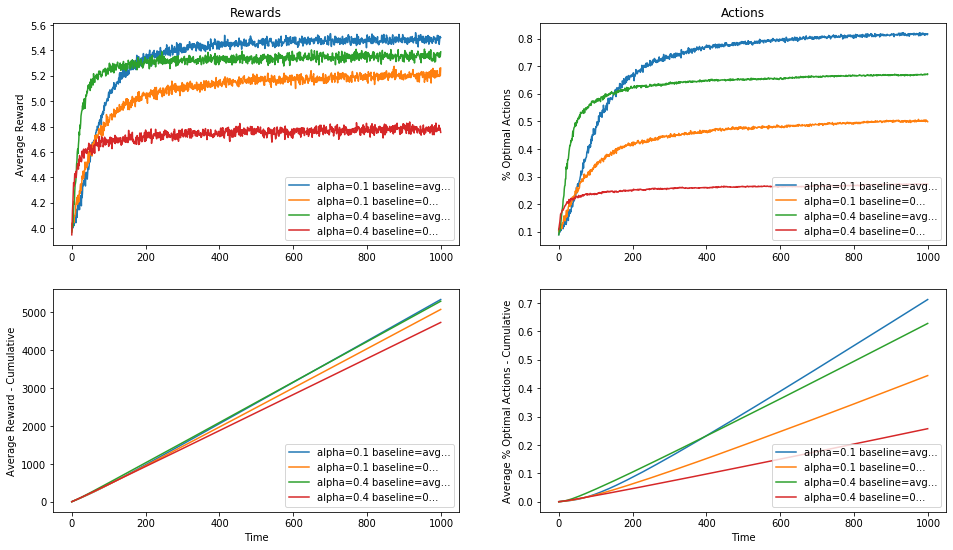

In [4]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 1

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

alpha = 0.1
baseline = None
name = 'alpha={} baseline=avg...'.format(alpha) 
start = time.time()
print('Running {}'.format(name))
t_H, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, alpha, baseline=baseline)
returns[name] = {'H':t_H, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

alpha = 0.1
baseline = 0.0
name = 'alpha={} baseline=0...'.format(alpha) 
start = time.time()
print('Running {}'.format(name))    
t_H, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, alpha, baseline=baseline)
returns[name] = {'H':t_H, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

alpha = 0.4
baseline = None
name = 'alpha={} baseline=avg...'.format(alpha) 
start = time.time()
print('Running {}'.format(name))    
t_H, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, alpha, baseline=baseline)
returns[name] = {'H':t_H, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

alpha = 0.4
baseline = 0.0
name = 'alpha={} baseline=0...'.format(alpha) 
start = time.time()
print('Running {}'.format(name))    
t_H, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, alpha, baseline=baseline)
returns[name] = {'H':t_H, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)   

plot_results(returns)